In [2]:
import pandas as pd

df = pd.read_csv("Housing.csv", sep=",")
print(df)

        price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    13300000  7420         4          2        3      yes        no       no   
1    12250000  8960         4          4        4      yes        no       no   
2    12250000  9960         3          2        2      yes        no      yes   
3    12215000  7500         4          2        2      yes        no      yes   
4    11410000  7420         4          1        2      yes       yes      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
540   1820000  3000         2          1        1      yes        no      yes   
541   1767150  2400         3          1        1       no        no       no   
542   1750000  3620         2          1        1      yes        no       no   
543   1750000  2910         3          1        1       no        no       no   
544   1750000  3850         3          1        2      yes        no       no   

    hotwaterheating aircond

In [3]:
X = df.loc[:, ["area", "bedrooms", "bathrooms", "stories", "parking"]]
y = df.loc[:, "price"]
print(X)
print(y)

     area  bedrooms  bathrooms  stories  parking
0    7420         4          2        3        2
1    8960         4          4        4        3
2    9960         3          2        2        2
3    7500         4          2        2        3
4    7420         4          1        2        2
..    ...       ...        ...      ...      ...
540  3000         2          1        1        2
541  2400         3          1        1        0
542  3620         2          1        1        0
543  2910         3          1        1        0
544  3850         3          1        2        0

[545 rows x 5 columns]
0      13300000
1      12250000
2      12250000
3      12215000
4      11410000
         ...   
540     1820000
541     1767150
542     1750000
543     1750000
544     1750000
Name: price, Length: 545, dtype: int64


In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)

print(model.coef_)

print(model.rank_)

print(model.singular_)

print(model.intercept_)

print(model.n_features_in_)

print(model.score(X,y))

[3.31115495e+02 1.67809788e+05 1.13374016e+06 5.47939810e+05
 3.77596289e+05]
5
[5.06159523e+04 2.29711586e+01 1.88067029e+01 1.40549153e+01
 1.01386305e+01]
-145734.48945587967
5
0.5615825438679802


Now, instead of using the built-in linear-regression model provided by `scikit-learn`, we will compute the weights explicitly using `numpy`. 

We first append a column of ones to our matrix, $X$. This is necessary in order to for the outputted model to have an intercept, otherwise the result of the function will be zero when all variables are zero.

In [5]:
import numpy as np

N = y.shape

X_mat = np.c_[np.ones(N),np.array(X)]
y_vec = np.array(y)

We now use Proposition 3.1 from Bach, which states that the ordinary least squares estimator exists and is given by
$$ \hat{\boldsymbol{\theta}} = \left(\Phi^T\Phi\right)^{-1}\Phi^T\mathbf{y}, $$
where $\Phi$ is the matrix of inputs, and $\mathbf{y}$ the vector of outputs.


In [6]:
from numpy.linalg import inv

A = np.transpose(X_mat) @ X_mat

B = inv(A)

C = B @ np.transpose(X_mat)

theta = C @ y_vec

print(theta)

[-1.45734489e+05  3.31115495e+02  1.67809788e+05  1.13374016e+06
  5.47939810e+05  3.77596289e+05]


However, this approach (in particular, computing the matrix inverse) may be computationally expensive! We will go on to find a method that is more efficient. Now, though, we generate our own data samples $(x_i,y_i)$, where the $x_i$ are iid Uniform on $[0,1]$, and 
$$ y_i = x_i^4 - 6x_i^2 + 5 + \delta_i, $$
where the $\delta_i$ are iid Normal $(0,\sigma)$ and represent noise. Thus, we may call these noisy samples.

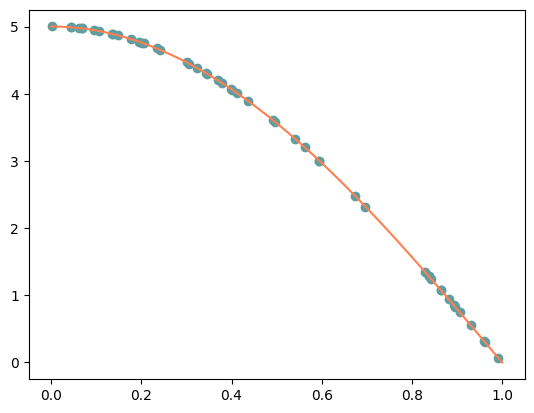

In [7]:
import matplotlib.pyplot as plt

x_range = np.linspace(0,1,1000)

N = 50

x = np.random.rand(N)

mu = 0
sigma = 0.001
noise = np.random.normal(mu,sigma,N)

y = x**4 - 6*x**2 + 5 + noise

plt.scatter(x,y, color = 'cadetblue')
plt.plot(x_range,[x_**4 - 6*x_**2 + 5 for x_ in x_range], color = 'coral')


Having produced our samples, we now use the built-in linear regression model from `scikit-learn` - for our input matrix, we seek to find an approximation using the basis functions $1,x,x^2,x^3,x^4$. As the underlying model is itself polynomial, we hope that these will do a good job of approximating it - indeed, we can compare our output weights $\boldsymbol{\theta}$ with the coefficients of the underlying model.

coefficients:
[ 5.00077085 -0.01325659 -5.93828082 -0.1064217   1.05827591]


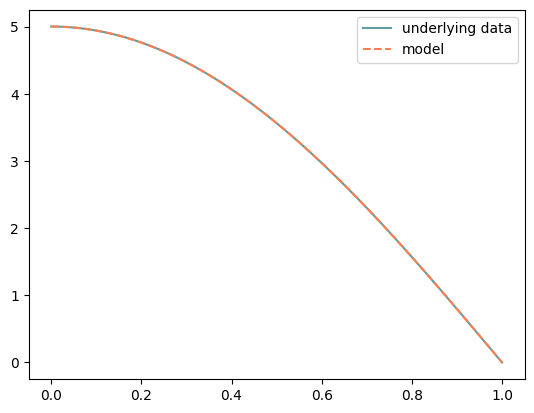

In [8]:
X = np.c_[np.ones(N), x, x**2, x**3, x**4]

model = LinearRegression(fit_intercept=False).fit(X, y)

coeffs = model.coef_

print("coefficients:")
print(coeffs)

plt.plot(x_range,[x_**4 - 6*x_**2 + 5 for x_ in x_range], color = 'cadetblue', label = 'underlying data')
plt.plot(x_range, [coeffs[0] + coeffs[1]*x_ + coeffs[2]*x_**2 + coeffs[3]*x_**3 + coeffs[4]*x_**4 for x_ in x_range], color = 'coral', linestyle = '--', label = 'model')

plt.legend()


As before, rather than using the built-in linear regression model, we can compute the weights 'manually' using the formula, 
$$ \hat{\boldsymbol{\theta}} = \left(\Phi^T\Phi\right)^{-1}\Phi^T\mathbf{y}. $$

coefficients:
[ 5.00077085 -0.01325659 -5.93828082 -0.1064217   1.05827591]
empirical risk - sklearn:
4.1654545803476535e-07
empirical risk - manual:
4.1654545803489024e-07


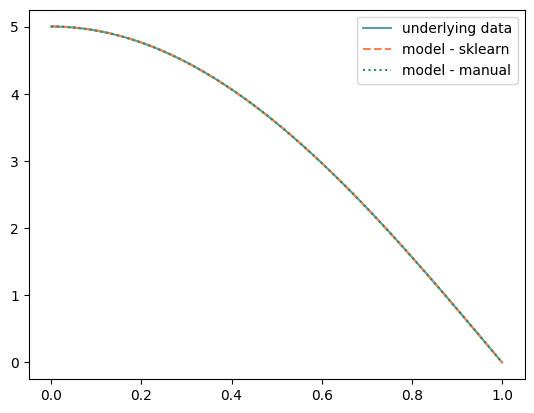

In [9]:
A = np.transpose(X) @ X

B = inv(A)

C = B @ np.transpose(X)

coeffs2 = C @ y

print("coefficients:")
print(coeffs2)

print("empirical risk - sklearn:")
print(sum((y - X @ coeffs)**2)/N)

print("empirical risk - manual:")
print(sum((y - X @ coeffs2)**2)/N)

plt.plot(x_range,[x_**4 - 6*x_**2 + 5 for x_ in x_range], color = 'cadetblue', label = 'underlying data')
plt.plot(x_range, [coeffs[0] + coeffs[1]*x_ + coeffs[2]*x_**2 + coeffs[3]*x_**3 + coeffs[4]*x_**4 for x_ in x_range], color = 'coral', linestyle = '--', label = 'model - sklearn')
plt.plot(x_range, [coeffs2[0] + coeffs2[1]*x_ + coeffs2[2]*x_**2 + coeffs2[3]*x_**3 + coeffs2[4]*x_**4 for x_ in x_range], color = 'seagreen', linestyle = ':', label = 'model - manual')

plt.legend()

Finally, we seek to improve the efficiency of the above method by using a QR decomposition. Indeed, we write $\Phi = QR$, where $Q$ has orthonormal columns (which means $Q^TQ = I$) and $R$ is upper triangular. With this in mind, we can rewrite the equation
$$ \left(\Phi^T\Phi\right)\boldsymbol{\theta} = \Phi^T\mathbf{y} $$
as
$$ R^TR\boldsymbol{\theta} = R^TQ^T\mathbf{y}, $$
which is equivalent to solving the system of equations,
$$ R\boldsymbol{\theta} = Q^T\mathbf{y}. $$
So the task of finding the weights $\boldsymbol{\theta}$ is nothing more than finding the vector $Q^T\mathbf{y}$, and then solving the resulting system of equations, which is easy as $R$ is upper triangular.

In [10]:
from numpy.linalg import qr
from scipy.linalg import solve_triangular

Q, R = qr(X)

Qty = np.transpose(Q) @ y

coeffs3 = solve_triangular(R, Qty)

print("coefficients:")
print(coeffs3)

print("empirical risk - QR:")
print(sum((y - X @ coeffs3)**2)/N)

coefficients:
[ 5.00077085 -0.01325659 -5.93828082 -0.1064217   1.05827591]
empirical risk - QR:
4.1654545803478954e-07


As a final exercise, we are interested how well our linear regression model works when the amplitude of the noise is varied. To investigate this, we choose to just use the built-in model from `scikit-learn`; for each level of noise, we find the linear regression model and compute the empirical risk of this model from the training data.

When we plot this risk (which can also be thought of as an error) against the different noise levels in the log-log scale, we find a straight line with gradient 2, which indicates a square-law dependence.

gradient:
1.992941541809086


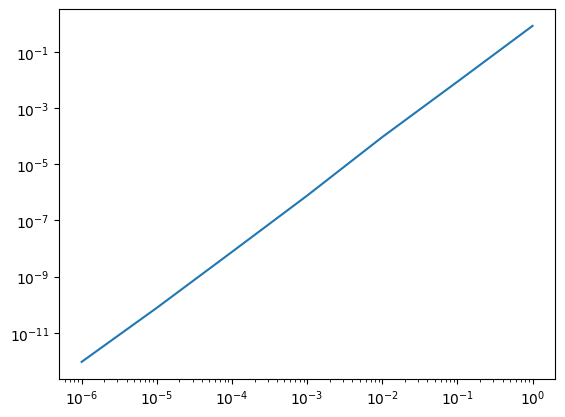

In [11]:
x = np.random.rand(N)

sigma_list = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]

scores = np.zeros(len(sigma_list))

for i in range(len(sigma_list)):
    mu = 0
    sigma = sigma_list[i]
    noise = np.random.normal(mu,sigma,N)

    y = x**4 - 6*x**2 + 5 + noise

    X = np.c_[np.ones(N), x, x**2, x**3, x**4]

    model = LinearRegression(fit_intercept=False).fit(X, y)

    coeffs = model.coef_

    scores[i] = sum((y - X @ coeffs)**2)/N

plt.loglog(sigma_list,scores)

print("gradient:")
print((np.log(scores[-1])-np.log(scores[0]))/(np.log(sigma_list[-1])-np.log(sigma_list[0])))
    